# Начальная конфигурация

In [1]:
import os
import time
import random
from pathlib import Path
from typing import Tuple, List, Dict

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import torchvision.transforms as transforms
from torchvision import models

from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

import warnings

warnings.filterwarnings('ignore')


In [2]:
from config import (
    CAT_IMAGES_DIR, DOG_IMAGES_DIR, IMAGE_SIZE, MEAN, STD,
    BATCH_SIZE, NUM_WORKERS, LEARNING_RATE, WEIGHT_DECAY,
    CNN_EPOCHS, TRANSFER_EPOCHS, VAL_SPLIT, TEST_SPLIT,
    RANDOM_SEED, LOG_DIR
)

In [3]:
def set_seed(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(RANDOM_SEED)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")



Используемое устройство: cpu


## Загрузка и подготовка данных


In [5]:
def get_image_paths(directory: str, label: int) -> List[Tuple[str, int]]:
    valid_extensions = {'.jpg', '.jpeg', '.png', '.gif', '.webp'}
    image_paths = []

    for filename in os.listdir(directory):
        ext = Path(filename).suffix.lower()
        if ext in valid_extensions:
            filepath = os.path.join(directory, filename)
            image_paths.append((filepath, label))

    return image_paths

In [6]:
def load_dataset_paths() -> List[Tuple[str, int]]:
    cats = get_image_paths(CAT_IMAGES_DIR, label=0)
    dogs = get_image_paths(DOG_IMAGES_DIR, label=1)

    print(f"Загружено котов: {len(cats)}")
    print(f"Загружено собак: {len(dogs)}")
    print(f"Всего изображений: {len(cats) + len(dogs)}")

    return cats + dogs

In [7]:
all_data = load_dataset_paths()
random.shuffle(all_data)

Загружено котов: 1050
Загружено собак: 1050
Всего изображений: 2100


## Датасет и трансформации

In [8]:
class CatDogDataset(Dataset):
    def __init__(self, data: List[Tuple[str, int]], transform=None):
        self.data = data
        self.transform = transform

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        img_path, label = self.data[idx]

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

In [9]:
def get_train_transform() -> transforms.Compose:
    """Трансформации для обучающей выборки с аугментацией"""
    return transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=MEAN, std=STD)
    ])


def get_val_transform() -> transforms.Compose:
    """Трансформации для валидационной/тестовой выборки"""
    return transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=MEAN, std=STD)
    ])

## Разделение данных на train/val/test

In [10]:
def split_data(data: List, val_split: float, test_split: float) -> Tuple[List, List, List]:
    total = len(data)
    test_size = int(total * test_split)
    val_size = int(total * val_split)
    train_size = total - val_size - test_size

    train_data = data[:train_size]
    val_data = data[train_size:train_size + val_size]
    test_data = data[train_size + val_size:]

    print(f"Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}")

    return train_data, val_data, test_data

In [11]:
train_data, val_data, test_data = split_data(all_data, VAL_SPLIT, TEST_SPLIT)

Train: 1470, Val: 315, Test: 315


In [12]:
train_dataset = CatDogDataset(train_data, transform=get_train_transform())
val_dataset = CatDogDataset(val_data, transform=get_val_transform())
test_dataset = CatDogDataset(test_data, transform=get_val_transform())

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

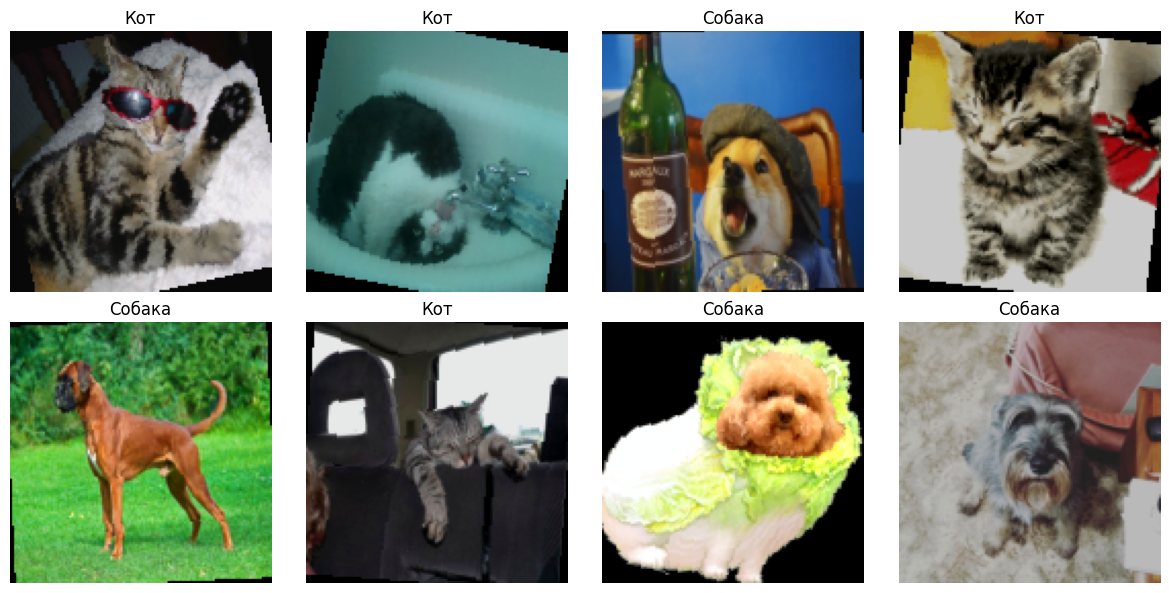

In [13]:
def show_sample_images(dataset: CatDogDataset, n_samples: int = 8) -> None:
    """Показывает примеры изображений из датасета"""
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))

    indices = random.sample(range(len(dataset)), n_samples)

    for ax, idx in zip(axes.flatten(), indices):
        img, label = dataset[idx]

        # Денормализация
        img = img.numpy().transpose(1, 2, 0)
        img = img * np.array(STD) + np.array(MEAN)
        img = np.clip(img, 0, 1)

        ax.imshow(img)
        ax.set_title("Кот" if label == 0 else "Собака")
        ax.axis('off')

    plt.tight_layout()
    plt.show()


show_sample_images(train_dataset)

# CNN архитектура

In [14]:
class ConvBlock(nn.Module):
    """Сверточный блок: Conv -> BatchNorm -> ReLU -> MaxPool"""

    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.block(x)

In [15]:
class CatDogCNN(nn.Module):
    """
    CNN для классификации котов и собак.
    - Архитектура: 5 сверточных блоков + 3 полносвязных слоя
    """

    def __init__(self, num_classes: int = 2):
        super().__init__()

        # Сверточная часть (feature extractor)
        self.features = nn.Sequential(
            ConvBlock(3, 32),     # 128 -> 64
            ConvBlock(32, 64),    # 64 -> 32
            ConvBlock(64, 128),   # 32 -> 16
            ConvBlock(128, 256),  # 16 -> 8
            ConvBlock(256, 512),  # 8 -> 4
        )

        # Глобальный пулинг
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Классификатор
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.global_pool(x)
        x = self.classifier(x)
        return x

    def get_embeddings(self, x: torch.Tensor) -> torch.Tensor:
        """Извлекает эмбеддинги из предпоследнего слоя"""
        x = self.features(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)

        # Первые слои классификатора до предпоследнего
        x = self.classifier[0](x)  # Flatten
        x = self.classifier[1](x)  # Linear 512 -> 256
        x = self.classifier[2](x)  # ReLU
        x = self.classifier[3](x)  # Dropout
        x = self.classifier[4](x)  # Linear 256 -> 64

        return x

In [16]:
def count_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


cnn_model = CatDogCNN().to(device)
print(f"Архитектура CNN:\n{cnn_model}")
print(f"\nКоличество параметров: {count_parameters(cnn_model):,}")



Архитектура CNN:
CatDogCNN(
  (features): Sequential(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): ConvBlock(
      (block): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine

# Функции обучения и валидации модели

In [17]:
def train_epoch(model: nn.Module, loader: DataLoader, criterion: nn.Module,
                optimizer: optim.Optimizer, device: torch.device) -> Tuple[float, float]:
    # Одна эпоха обучения модели
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    avg_loss = total_loss / total
    accuracy = correct / total

    return avg_loss, accuracy

In [18]:
def validate(model: nn.Module, loader: DataLoader, criterion: nn.Module,
             device: torch.device) -> Tuple[float, float]:
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    avg_loss = total_loss / total
    accuracy = correct / total

    return avg_loss, accuracy

In [19]:
def train_model(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader,
                criterion: nn.Module, optimizer: optim.Optimizer,
                scheduler: optim.lr_scheduler._LRScheduler,
                n_epochs: int, device: torch.device,
                model_name: str = "model") -> Dict:
    # Полный цикл обучения
    writer = SummaryWriter(log_dir=os.path.join(LOG_DIR, model_name))

    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    best_val_acc = 0.0
    start_time = time.time()

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(
            model, train_loader, criterion, optimizer, device
        )
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        scheduler.step()

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # TensorBoard
        writer.add_scalars('Loss', {'train': train_loss, 'val': val_loss}, epoch)
        writer.add_scalars('Accuracy', {'train': train_acc, 'val': val_acc}, epoch)
        writer.add_scalar('LearningRate', optimizer.param_groups[0]['lr'], epoch)

        # Лучшая модель
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f'{model_name}_best.pth')

        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch [{epoch + 1:3d}/{n_epochs}] | "
                  f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    total_time = time.time() - start_time
    history['training_time'] = total_time
    history['best_val_acc'] = best_val_acc

    writer.close()

    print(f"\nОбучение завершено за {total_time:.1f} сек")
    print(f"Лучшая Val Accuracy: {best_val_acc:.4f}")

    return history

## Обучение модели CNN с нуля

In [20]:
cnn_model = CatDogCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(cnn_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CNN_EPOCHS)

print("Обучение CNN с нуля:")
cnn_history = train_model(
    cnn_model, train_loader, val_loader,
    criterion, optimizer, scheduler,
    n_epochs=CNN_EPOCHS, device=device,
    model_name="cnn_from_scratch"
)

Обучение CNN с нуля:
Epoch [  1/15] | Train Loss: 0.6521, Acc: 0.6034 | Val Loss: 0.6673, Acc: 0.5937
Epoch [  5/15] | Train Loss: 0.6224, Acc: 0.6361 | Val Loss: 0.6591, Acc: 0.5905
Epoch [ 10/15] | Train Loss: 0.6156, Acc: 0.6503 | Val Loss: 0.6472, Acc: 0.6063
Epoch [ 15/15] | Train Loss: 0.5823, Acc: 0.6776 | Val Loss: 0.6266, Acc: 0.6127

Обучение завершено за 2214.2 сек
Лучшая Val Accuracy: 0.6222


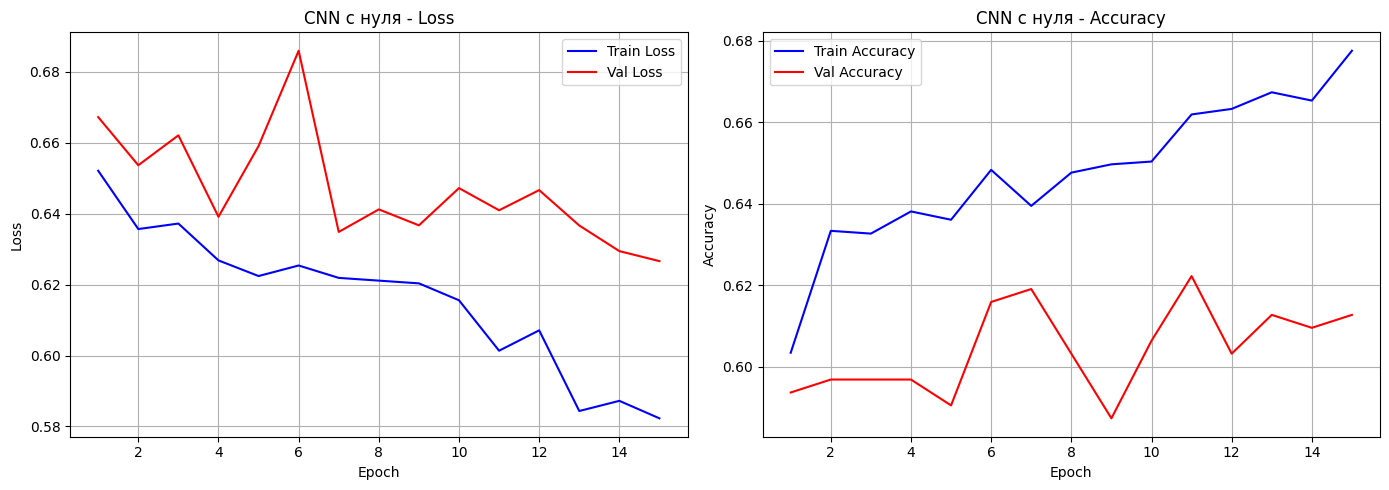

In [21]:
def plot_training_history(history: Dict, title: str) -> None:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    epochs = range(1, len(history['train_loss']) + 1)

    # Loss
    axes[0].plot(epochs, history['train_loss'], 'b-', label='Train Loss')
    axes[0].plot(epochs, history['val_loss'], 'r-', label='Val Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title(f'{title} - Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Accuracy
    axes[1].plot(epochs, history['train_acc'], 'b-', label='Train Accuracy')
    axes[1].plot(epochs, history['val_acc'], 'r-', label='Val Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title(f'{title} - Accuracy')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()


plot_training_history(cnn_history, "CNN с нуля")

## Оценка модели CNN на тестовых данных

In [22]:
def evaluate_model(model: nn.Module, test_loader: DataLoader,
                   device: torch.device, model_path: str = None) -> Dict:
    if model_path and os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path, map_location=device))

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = outputs.max(1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test F1-Score: {f1:.4f}")
    print("-" * 60)
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=['Кот', 'Собака']))

    return {'accuracy': accuracy, 'f1': f1, 'preds': all_preds, 'labels': all_labels}

In [23]:
cnn_results = evaluate_model(cnn_model, test_loader, device, "cnn_from_scratch_best.pth")

Test Accuracy: 0.6667
Test F1-Score: 0.6506
------------------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

         Кот       0.63      0.87      0.73       164
      Собака       0.76      0.45      0.56       151

    accuracy                           0.67       315
   macro avg       0.69      0.66      0.65       315
weighted avg       0.69      0.67      0.65       315



### Матрица ошибок

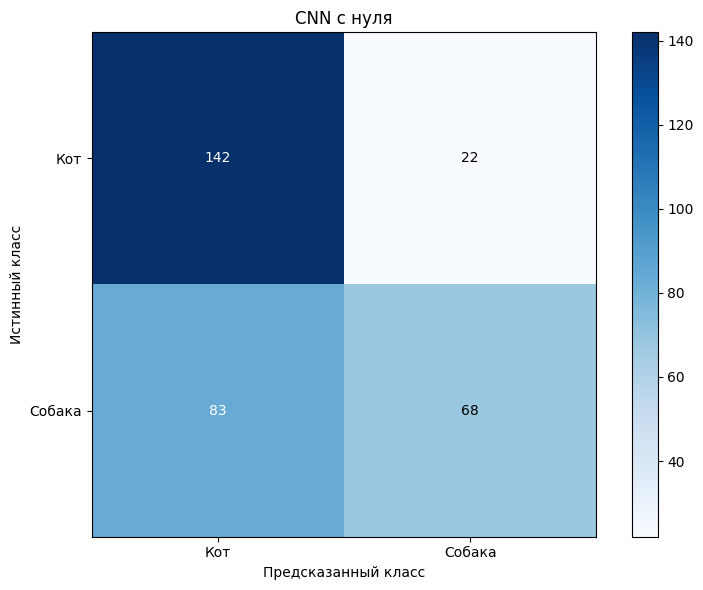

In [24]:
def plot_confusion_matrix(labels: List, preds: List, title: str) -> None:
    cm = confusion_matrix(labels, preds)

    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    classes = ['Кот', 'Собака']
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Истинный класс',
           xlabel='Предсказанный класс')

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.show()


plot_confusion_matrix(cnn_results['labels'], cnn_results['preds'], "CNN с нуля")

## Создание эмбеддингов и визуализация через t-SNE

In [25]:
def extract_embeddings(model: nn.Module, loader: DataLoader,
                       device: torch.device) -> Tuple[np.ndarray, np.ndarray]:
    model.eval()
    embeddings = []
    labels = []

    with torch.no_grad():
        for images, batch_labels in tqdm(loader, desc="Извлечение эмбеддингов"):
            images = images.to(device)
            emb = model.get_embeddings(images)
            embeddings.append(emb.cpu().numpy())
            labels.extend(batch_labels.numpy())

    embeddings = np.vstack(embeddings)
    labels = np.array(labels)

    return embeddings, labels

In [26]:
# Загружаем лучшую модель
cnn_model.load_state_dict(torch.load("cnn_from_scratch_best.pth", map_location=device))

# Извлекаем эмбеддинги из тестовых данных
embeddings, labels = extract_embeddings(cnn_model, test_loader, device)
print(f"Размерность эмбеддингов: {embeddings.shape}")

Извлечение эмбеддингов:   0%|          | 0/10 [00:00<?, ?it/s]

Размерность эмбеддингов: (315, 64)


Вычисление t-SNE:


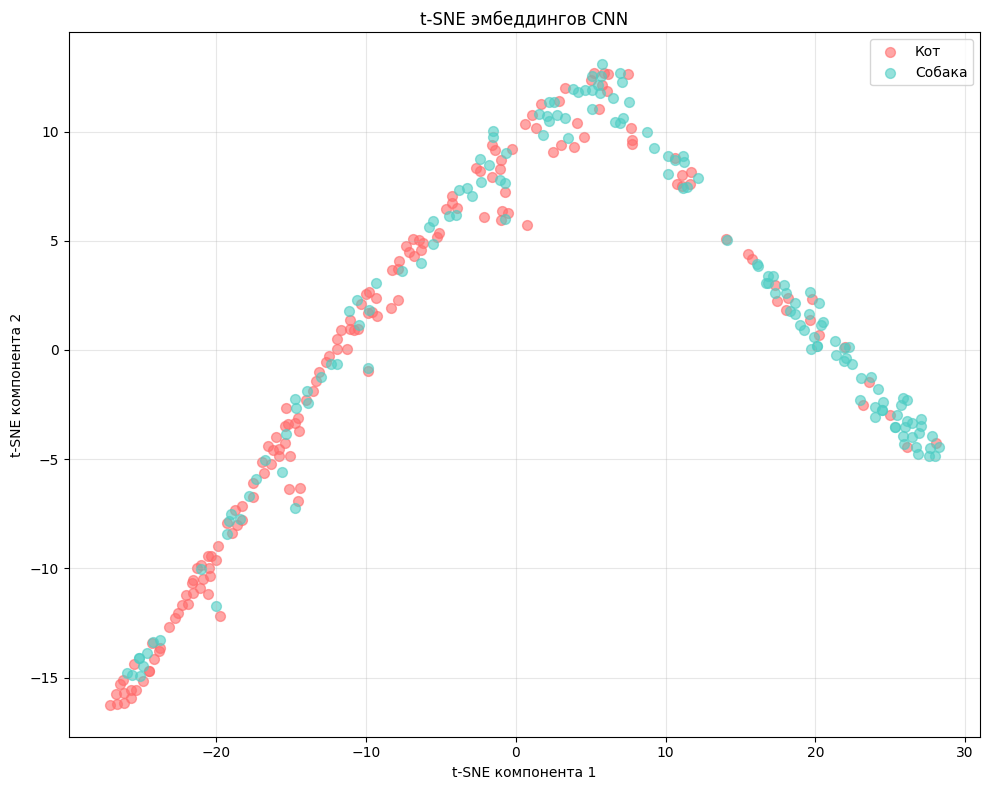

In [27]:
def plot_tsne(embeddings: np.ndarray, labels: np.ndarray, title: str) -> None:
    print("Вычисление t-SNE:")
    tsne = TSNE(n_components=2, random_state=RANDOM_SEED, perplexity=30)
    embeddings_2d = tsne.fit_transform(embeddings)

    plt.figure(figsize=(10, 8))

    colors = ['#FF6B6B', '#4ECDC4']
    class_names = ['Кот', 'Собака']

    for class_idx in [0, 1]:
        mask = labels == class_idx
        plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1],
                    c=colors[class_idx], label=class_names[class_idx],
                    alpha=0.6, s=50)

    plt.xlabel('t-SNE компонента 1')
    plt.ylabel('t-SNE компонента 2')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


plot_tsne(embeddings, labels, "t-SNE эмбеддингов CNN")

## Transfer Learning модель с ResNet18

In [28]:
class TransferModel(nn.Module):
    def __init__(self, num_classes: int = 2, freeze_backbone: bool = True):
        super().__init__()

        self.backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False

        in_features = self.backbone.fc.in_features

        # Замена полносвязного слоя на свой классификатор
        self.backbone.fc = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.backbone(x)

    def get_embeddings(self, x: torch.Tensor) -> torch.Tensor:
        """Извлекает эмбеддинги из предпоследнего слоя"""
        # Все слои кроме fc
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)
        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)
        x = self.backbone.avgpool(x)
        x = torch.flatten(x, 1)

        # Кастомные слои до предпоследнего
        fc = self.backbone.fc
        x = fc[0](x)  # Linear -> 256
        x = fc[1](x)  # ReLU
        x = fc[2](x)  # Dropout
        x = fc[3](x)  # Linear -> 64

        return x

In [29]:
transfer_model = TransferModel(freeze_backbone=True).to(device)

trainable_params = sum(p.numel() for p in transfer_model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in transfer_model.parameters())

print(f"Всего параметров: {total_params:,}")
print(f"Обучаемых параметров: {trainable_params:,}")
print(f"Замороженных: {total_params - trainable_params:,}")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\timsl/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:01<00:00, 30.9MB/s]


Всего параметров: 11,324,418
Обучаемых параметров: 147,906
Замороженных: 11,176,512


## Обучение Transfer Learning модели с замороженным бэкбоном

In [30]:
transfer_model = TransferModel(freeze_backbone=True).to(device)

criterion = nn.CrossEntropyLoss()
# Только параметры классификатора
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, transfer_model.parameters()),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=TRANSFER_EPOCHS)

print("Обучение Transfer Learning модели:")
transfer_history = train_model(
    transfer_model, train_loader, val_loader,
    criterion, optimizer, scheduler,
    n_epochs=TRANSFER_EPOCHS, device=device,
    model_name="transfer_resnet18"
)

Обучение Transfer Learning модели:
Epoch [  1/15] | Train Loss: 0.5146, Acc: 0.7388 | Val Loss: 0.3243, Acc: 0.8571
Epoch [  5/15] | Train Loss: 0.3417, Acc: 0.8544 | Val Loss: 0.2875, Acc: 0.8984
Epoch [ 10/15] | Train Loss: 0.2989, Acc: 0.8646 | Val Loss: 0.2975, Acc: 0.8857
Epoch [ 15/15] | Train Loss: 0.2924, Acc: 0.8748 | Val Loss: 0.3010, Acc: 0.8762

Обучение завершено за 1128.6 сек
Лучшая Val Accuracy: 0.8984


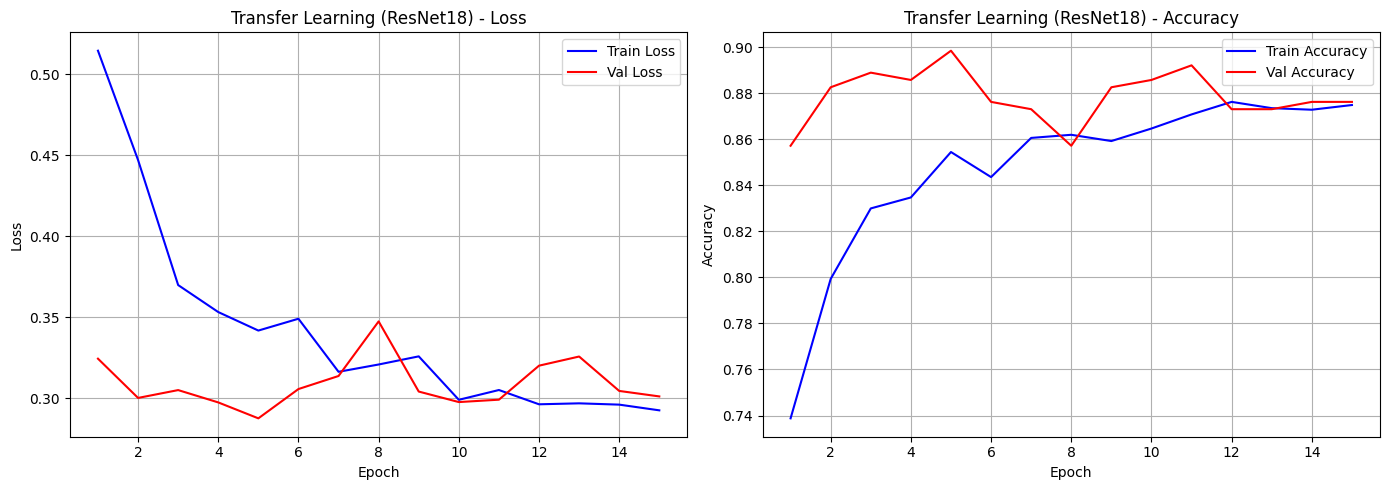

In [31]:
plot_training_history(transfer_history, "Transfer Learning (ResNet18)")

## Оценка Transfer Learning модели на тестовых данных

In [32]:
transfer_results = evaluate_model(
    transfer_model, test_loader, device,
    "transfer_resnet18_best.pth"
)

Test Accuracy: 0.8444
Test F1-Score: 0.8429
------------------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

         Кот       0.80      0.93      0.86       164
      Собака       0.90      0.75      0.82       151

    accuracy                           0.84       315
   macro avg       0.85      0.84      0.84       315
weighted avg       0.85      0.84      0.84       315



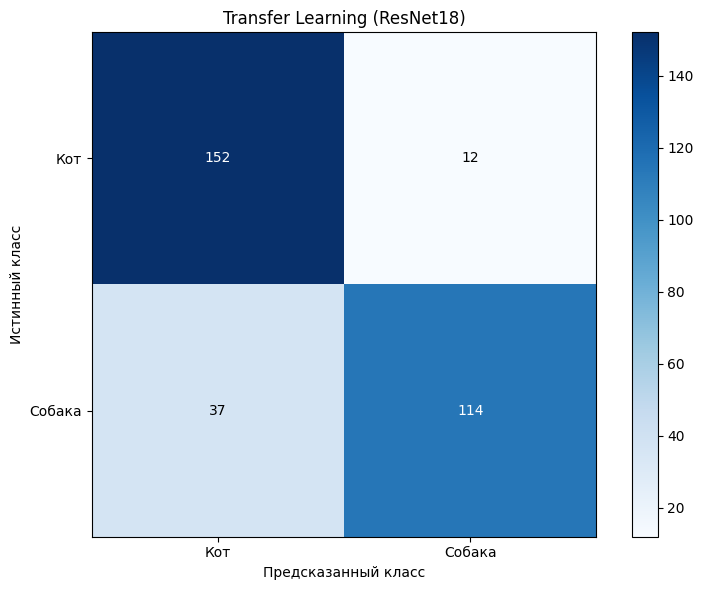

In [33]:
plot_confusion_matrix(
    transfer_results['labels'],
    transfer_results['preds'],
    "Transfer Learning (ResNet18)"
)

Извлечение эмбеддингов:   0%|          | 0/10 [00:00<?, ?it/s]

Вычисление t-SNE:


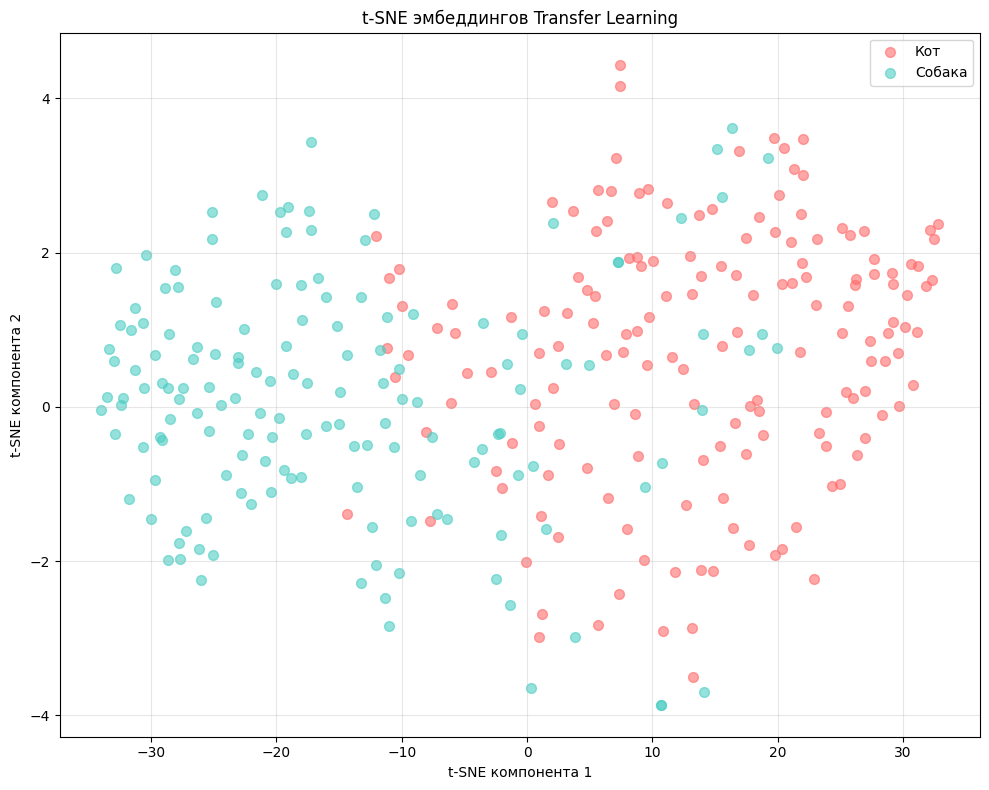

In [34]:
transfer_model.load_state_dict(torch.load("transfer_resnet18_best.pth", map_location=device))
transfer_embeddings, transfer_labels = extract_embeddings(transfer_model, test_loader, device)
plot_tsne(transfer_embeddings, transfer_labels, "t-SNE эмбеддингов Transfer Learning")

## Сравнение моделей

In [35]:
def compare_models(cnn_history: Dict, transfer_history: Dict,
                   cnn_results: Dict, transfer_results: Dict) -> None:

    print("Сравнение моделей CNN с нуля и Transfer Learning:")
    print("-" * 60)

    comparison = {
        'Метрика': ['Test Accuracy', 'Test F1-Score', 'Best Val Accuracy',
                    'Время обучения (сек)', 'Количество эпох'],
        'CNN с нуля': [
            f"{cnn_results['accuracy']:.4f}",
            f"{cnn_results['f1']:.4f}",
            f"{cnn_history['best_val_acc']:.4f}",
            f"{cnn_history['training_time']:.1f}",
            CNN_EPOCHS
        ],
        'Transfer Learning': [
            f"{transfer_results['accuracy']:.4f}",
            f"{transfer_results['f1']:.4f}",
            f"{transfer_history['best_val_acc']:.4f}",
            f"{transfer_history['training_time']:.1f}",
            TRANSFER_EPOCHS
        ]
    }

    print(f"{'Метрика':<25} {'CNN с нуля':<20} {'Transfer Learning':<20}")
    print("-" * 65)

    for i, metric in enumerate(comparison['Метрика']):
        cnn_val = comparison['CNN с нуля'][i]
        transfer_val = comparison['Transfer Learning'][i]
        print(f"{metric:<25} {cnn_val:<20} {transfer_val:<20}")

    print("-" * 60)


compare_models(cnn_history, transfer_history, cnn_results, transfer_results)

Сравнение моделей CNN с нуля и Transfer Learning:
------------------------------------------------------------
Метрика                   CNN с нуля           Transfer Learning   
-----------------------------------------------------------------
Test Accuracy             0.6667               0.8444              
Test F1-Score             0.6506               0.8429              
Best Val Accuracy         0.6222               0.8984              
Время обучения (сек)      2214.2               1128.6              
Количество эпох           15                   15                  
------------------------------------------------------------


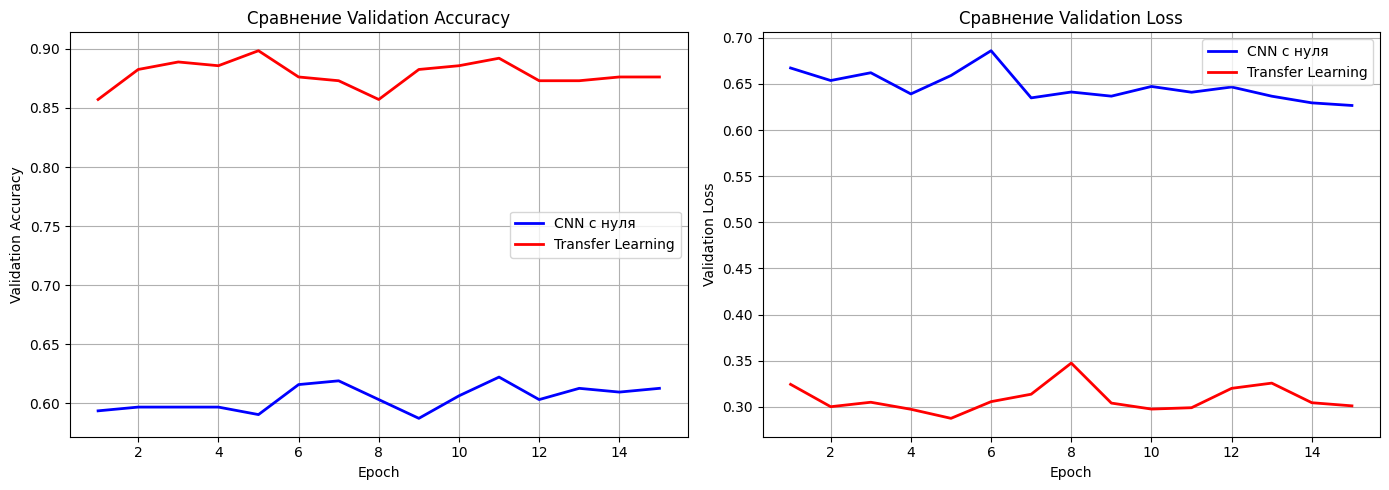

In [36]:
def plot_comparison(cnn_history: Dict, transfer_history: Dict) -> None:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy
    cnn_epochs = range(1, len(cnn_history['val_acc']) + 1)
    transfer_epochs = range(1, len(transfer_history['val_acc']) + 1)

    axes[0].plot(cnn_epochs, cnn_history['val_acc'], 'b-', label='CNN с нуля', linewidth=2)
    axes[0].plot(transfer_epochs, transfer_history['val_acc'], 'r-', label='Transfer Learning', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Validation Accuracy')
    axes[0].set_title('Сравнение Validation Accuracy')
    axes[0].legend()
    axes[0].grid(True)

    # Loss
    axes[1].plot(cnn_epochs, cnn_history['val_loss'], 'b-', label='CNN с нуля', linewidth=2)
    axes[1].plot(transfer_epochs, transfer_history['val_loss'], 'r-', label='Transfer Learning', linewidth=2)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Validation Loss')
    axes[1].set_title('Сравнение Validation Loss')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()


plot_comparison(cnn_history, transfer_history)